In [9]:
import torch
import cv2
import numpy as np
from scipy.optimize import curve_fit

# Load MiDaS small model
def load_midas_model():
    model_type = "MiDaS_small"  # Use the smaller MiDaS model
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if torch.cuda.is_available():
        midas = midas.cuda()
    midas.eval()

    transform = midas_transforms.small_transform  # Use the transform designed for the small model
    return midas, transform

# Estimate depth using MiDaS
def estimate_depth(image, midas, transform):
    input_batch = transform(image).unsqueeze(0)  # Should be [1, 3, H, W]

# If there is an extra dimension:
    if input_batch.shape[1] == 1:  # Check if there is an extra dimension
        input_batch = input_batch.squeeze(1)  # Remove the extra dimension

    if torch.cuda.is_available():
        input_batch = input_batch.cuda()

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

# Calibration to translate relative depth to absolute distance
def calibrate_depth(relative_depths, actual_distances):
    def linear_model(x, a, b):
        return a * x + b

    popt, _ = curve_fit(linear_model, relative_depths, actual_distances)
    return popt  # Returns coefficients a and b

# Calculate absolute distances using the calibration
def calculate_absolute_distances(relative_depths, a, b):
    return a * np.array(relative_depths) + b

# Function to get the distance based on input coordinates
def get_distance_at_coordinates(image, midas, transform, coordinates, a, b):
    # Estimate the depth map
    depth_map = estimate_depth(image, midas, transform)

    # Extract relative depth values from the depth map at the specified coordinates
    relative_depths = [depth_map[y, x] for (x, y) in coordinates]

    # Calculate the absolute distances using the calibrated coefficients
    absolute_distances = calculate_absolute_distances(relative_depths, a, b)

    return absolute_distances

# Main function

# Load image and MiDaS model
# image = cv2.imread(r"C:\Users\gbo10\OneDrive\research\06.05.2024\vlcsnap-2024-08-22-14h13m30s762.png")  # Replace with your image path
# midas, transform = load_midas_model()

# Coordinates and actual distances obtained from ImageJ


In [5]:
# Example coordinates and actual distances (replace with actual values)
calibration_coordinates = [(3120,1596),(2597,389)] # Replace with coordinates from ImageJ
actual_distances = [650,620]  # Replace with the actual distances in meters

# Estimate the depth map
depth_map = estimate_depth(image, midas, transform)

# Extract relative depth values for calibration
relative_depths = [depth_map[y, x] for (x, y) in calibration_coordinates]

# Perform calibration to find coefficients a and b
a, b = calibrate_depth(relative_depths, actual_distances)

# Test: Get distance for a new set of coordinates
test_coordinates = [(1205, 1319)]  # Replace with test coordinates
distances = get_distance_at_coordinates(image, midas, transform, test_coordinates, a, b)

for i, coord in enumerate(test_coordinates):
    print(f"Distance at coordinate {coord}: {distances[i]} mm")

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (pad): ZeroPad2d((0, 1, 0, 1))
      )
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), strid

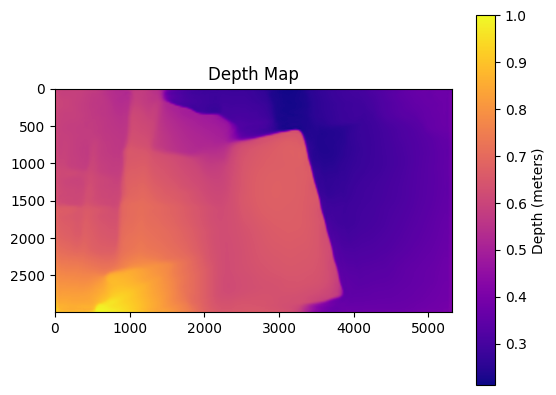

In [16]:
import matplotlib.pyplot as plt

# Normalize the depth map for better visualization (optional)
depth_map_normalized = depth_map / depth_map.max()


# Show the depth map using matplotlib
plt.imshow(depth_map_normalized, cmap='plasma')
plt.colorbar(label='Depth (meters)')
plt.title('Depth Map')
plt.show()


In [24]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", pretrained=False, force_reload=True)

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to path_to_your_cache_directory\master.zip


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_cache_directory\\isl-org-MiDaS-4545977\\mobile\\android\\lib_support\\src\\main\\java\\org\\tensorflow\\lite\\examples\\classification\\tflite\\ClassifierQuantizedEfficientNet.java'

In [19]:
import torch

torch.hub.set_dir('path_to_your_cache_directory')  # Optionally set a specific cache directory
torch.hub.list('intel-isl/MiDaS')  # This lists the available models and might refresh the cache
torch.hub._cache_dir = None  # Reset cache dir to default


c:\Users\gbo10\Videos\research\counting_research_algorithms\.venv\lib\site-packages\torch\hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or list(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use list(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to path_to_your_cache_directory\master.zip


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_cache_directory\\isl-org-MiDaS-4545977\\mobile\\android\\lib_support\\src\\main\\java\\org\\tensorflow\\lite\\examples\\classification\\tflite\\ClassifierQuantizedEfficientNet.java'

In [20]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the DPT_Hybrid model
model_url = "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt"
model_path = "dpt_hybrid_384.pt"

# Download the model manually
torch.hub.download_url_to_file(model_url, model_path)

# Load the model from the downloaded file
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", pretrained=False)
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
midas.load_state_dict(state_dict)

# Example usage:# Load image and MiDaS model
image = cv2.imread(r"C:\Users\gbo10\OneDrive\research\06.05.2024\vlcsnap-2024-08-22-14h13m30s762.png")  # Replace with your image path


# Load image and MiDaS model


100%|██████████| 470M/470M [04:04<00:00, 2.02MB/s] 
c:\Users\gbo10\Videos\research\counting_research_algorithms\.venv\lib\site-packages\torch\hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to path_to_your_cache_directory\master.zip


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_cache_directory\\isl-org-MiDaS-4545977\\mobile\\android\\lib_support\\src\\main\\java\\org\\tensorflow\\lite\\examples\\classification\\tflite\\ClassifierQuantizedEfficientNet.java'

In [23]:
import torch
torch.hub.empty_cache()

AttributeError: module 'torch.hub' has no attribute 'empty_cache'

In [22]:

# Load the model using the local file
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", pretrained=False)
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
midas.load_state_dict(state_dict)

# Now you can move the model to GPU if available
if torch.cuda.is_available():
    midas = midas.cuda()

midas.eval()

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to path_to_your_cache_directory\master.zip


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_cache_directory\\isl-org-MiDaS-4545977\\mobile\\android\\lib_support\\src\\main\\java\\org\\tensorflow\\lite\\examples\\classification\\tflite\\ClassifierQuantizedEfficientNet.java'

In [ ]:
# Example usage:


# Estimate the depth map
input_batch = transform(image).unsqueeze(0)  # Add a batch dimension

if torch.cuda.is_available():
    input_batch = input_batch.cuda()

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Normalize the depth map for better visualization
depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Visualize the depth map using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(depth_map_normalized, cmap='plasma', aspect='auto')
plt.colorbar(label='Depth (meters)')
plt.title('Depth Map')
plt.axis('off')
plt.show()


In [1]:
import torch
import cv2
import numpy as np
from scipy.optimize import curve_fit

import torch
import timm

import torch
import cv2
import timm
import numpy as np
from midas.model_loader import load_model

def load_midas_model():
    model_path = r"C:\Users\gbo10\OneDrive\research\06.05.2024\dpt_swin2_base_384.pt"
    
    # Load the MiDaS model
    midas = load_model(model_path=model_path, model_type="dpt_swin2_base_384",device="cpu")
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    midas.load_state_dict(state_dict, strict=False)
    # Define transform manually
    def transform(img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = cv2.resize(img, (384, 384), interpolation=cv2.INTER_CUBIC)
        img = torch.from_numpy(img).float().permute(2, 0, 1).unsqueeze(0)
        return img

    return midas, transform

# Rest of your code remains unchanged


    # Define transform manually



def estimate_depth(image, midas, transform):
    original_size = image.shape[:2]
    input_batch = transform(image)

    if torch.cuda.is_available():
        input_batch = input_batch.cuda()

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=original_size,
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

def calibrate_depth(relative_depths, actual_distances):
    def linear_model(x, a, b):
        return a * x + b

    popt, _ = curve_fit(linear_model, relative_depths, actual_distances)
    return popt  # Returns coefficients a and b

def calculate_absolute_distances(relative_depths, a, b):
    return a * np.array(relative_depths) + b

def get_distance_at_coordinates(image, midas, transform, coordinates, a, b):
    depth_map = estimate_depth(image, midas, transform)
    relative_depths = [depth_map[y, x] for (x, y) in coordinates]
    absolute_distances = calculate_absolute_distances(relative_depths, a, b)
    return absolute_distances

def main():
    # Load image and MiDaS model
    image_path = r"C:\Users\gbo10\OneDrive\research\06.05.2024\vlcsnap-2024-08-22-14h13m30s762.png"
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    print(f"Original image shape: {image.shape}")
    
    midas, transform = load_midas_model()

    # Your calibration data
    calibration_coordinates = [(3120,1596), (2597,389)]
    actual_distances = [650, 620]  # in meters

    # Estimate the depth map
    depth_map = estimate_depth(image, midas, transform)
    print(f"Depth map shape: {depth_map.shape}")

    # Ensure depth map has the same dimensions as the original image
    assert depth_map.shape == image.shape[:2], "Depth map size doesn't match original image size"

    # Extract relative depth values for calibration
    relative_depths = [depth_map[y, x] for (x, y) in calibration_coordinates]
    print(f"Relative depths at calibration points: {relative_depths}")

    # Perform calibration to find coefficients a and b
    a, b = calibrate_depth(relative_depths, actual_distances)
    print(f"Calibration coefficients: a = {a}, b = {b}")

    # Test: Get distance for a new set of coordinates
    test_coordinates = [(1205, 1319)]
    distances = get_distance_at_coordinates(image, midas, transform, test_coordinates, a, b)

    for i, coord in enumerate(test_coordinates):
        print(f"Distance at coordinate {coord}: {distances[i]:.2f} meters")

    # Optional: Visualize depth map
    normalized_depth = cv2.normalize(depth_map, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite("depth_map_visualization.png", normalized_depth)
    print("Depth map visualization saved as 'depth_map_visualization.png'")

if __name__ == "__main__":
    main()

c:\Users\gbo10\Videos\research\counting_research_algorithms\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'midas'